In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

current_dir = '/content/drive/MyDrive/Colab Notebooks/MHFN/Corr'
print(current_dir)
if current_dir not in sys.path:
    sys.path.append(current_dir)

!pip install torcheval
!pip install opencv-python

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torcheval.metrics import MulticlassF1Score, MulticlassAUROC, MulticlassConfusionMatrix

import MHFN_batch
from MHFN_batch import MHFN_layer

import cv2
from cv2 import GaussianBlur

/content/drive/MyDrive/Colab Notebooks/MHFN/Corr


##### Prepare patterns memory, evaluate data characteristics, check correct initialization and control that the calls for the layer actually work. Evaluate patterns number/temperature tradeoff and if increasing resolution of samples.

In [ ]:
# fixing seeds for deterministic behaviour
random.seed(0)
np.random.seed(0)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
class AddCorrelatedNoise(object):
    def __init__(self, mean=0., std=0.1, blur_kernel=(5,5)):
        self.mean = mean
        self.std = std
        self.blur_kernel = blur_kernel
    def __call__(self, tensor):
        noisy = tensor + torch.randn_like(tensor) * self.std + self.mean

        blurred = []
        for channel in noisy:
            ch_np = channel.detach().cpu().numpy().astype(np.float32)
            ch_blur = cv2.GaussianBlur(ch_np, self.blur_kernel, 0)
            tens = torch.from_numpy(ch_blur)
            blurred.append(tens)
            result = torch.stack(blurred).float()
            result = (result - result.min()) / (result.max() - result.min() + 1e-6)

        return result

transform = transforms.Compose([
    transforms.ToTensor(),
    AddCorrelatedNoise(0., 0.1, (7,7))
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
    )

In [ ]:
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

tensor(1.0000)
tensor(0.)


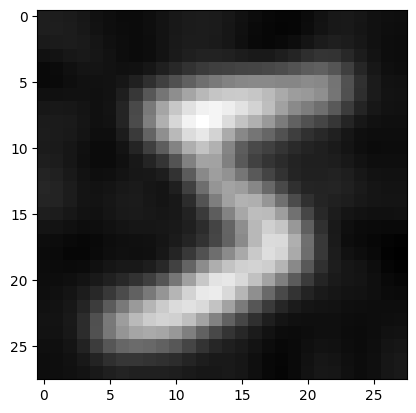

In [ ]:
plt.imshow(training_data[0][0][0], cmap='gray')
print(max(training_data[0][0][0].flatten()))
print(min(training_data[0][0][0].flatten()))

In [ ]:
class Classifier(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.feature_extractor = torch.nn.Sequential(
            self.make_block(1, 16),
            self.make_block(16, 32),
            self.make_block(32, 64),
            self.make_block(64, 128),
            # self.make_block(128, 256),
            # torch.nn.AvgPool2d(5),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(128, 10),
            #torch.nn.Softmax() torch.nn.CrossEntropyLoss already does that
        )

    def make_block(self, in_channels, out_channels):
        block = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        # torch.nn.BatchNorm2d(out_channels),
        # torch.nn.ReLU(),
        # torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.Dropout(0.1),
        torch.nn.ReLU()
        )
        return block

    def forward(self, x):
        features = self.feature_extractor(x)
        probs = self.classifier(features)
        return probs

device = 'cuda' if torch.cuda.is_available() else 'cpu'

classifier = Classifier()

##### Check if input is correct (size, noise)

In [ ]:
print('Device:', device)
classifier.to(device)

loss_fun = torch.nn.CrossEntropyLoss()
loss_fun.to(device)
LR = 0.001
optimizer = torch.optim.Adam(classifier.parameters(), lr=LR, weight_decay=1e-4)

f1_metric = MulticlassF1Score(num_classes=10)
conf_metric = MulticlassConfusionMatrix(num_classes=10, normalize='all')
auc_metric = MulticlassAUROC(num_classes=10, average=None)

epochs = 5
step = 0

classifier.train()

for epoch in range(epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        # plt.imshow(images[1][0].cpu(), cmap='gray')
        # break
        optimizer.zero_grad()
        probs = classifier(images)
        loss = loss_fun(probs.squeeze(1), labels)
        # print(loss.item())
        loss.backward()
        optimizer.step()
        step += 1
        if step % 50 == 0:
            preds = torch.argmax(probs, dim=1)
            acc = (preds.squeeze() == labels).float().mean()
            f1_metric.update(preds, labels)
            conf_metric.update(preds, labels)
            auc_metric.update(probs, labels)
            f1 = f1_metric.compute()
            conf = conf_metric.compute()
            auc = auc_metric.compute()

            print(f"{step}[{epoch}]: loss {loss.item()} acc:{100*acc:.1f}")
            print(f"f1:{f1}")
            print(f"conf:{conf}")
            print(f"auc:{auc}")


data = {"step": step,
        "classifier": classifier.state_dict(),
        "optimizer": optimizer.state_dict()}

Device: cuda
50[0]: loss 1.6239254474639893 acc:78.1
f1:0.78125
conf:tensor([[0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0312, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0938, 0.0000, 0.0000, 0.0312, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0312, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0312, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0312],
        [0.0000, 0.0000, 0.0312, 0.0000, 0.0000, 0.0312, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0312,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0312,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/Colab Notebooks/MHFN/Corr/"

In [ ]:
torch.save(data, PROJECT_DIR + 'classifier_corr_simple.pth')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

data = torch.load(PROJECT_DIR + 'classifier_corr_simple.pth', map_location=torch.device(device))
classifier = Classifier()
classifier.load_state_dict(data['classifier'])
classifier.to(device)

Device: cuda


Classifier(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
num_runs = 10
accs = []
f1s = []
confs = []
aucs = []

for run in range(num_runs):
    correct = 0
    total = 0
    f1_metric = MulticlassF1Score(num_classes=10)
    conf_metric = MulticlassConfusionMatrix(num_classes=10, normalize='true')
    auc_metric = MulticlassAUROC(num_classes=10, average=None)

    classifier.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # print(max(images[1][0].flatten()))
            # plt.imshow(images[1][0].cpu(), cmap='gray')
            # break

            probs = classifier(images)
            preds = torch.argmax(probs, dim=1)
            correct += (preds == labels).float().sum().item()
            total += len(labels)

            f1_metric.update(preds, labels)
            conf_metric.update(preds, labels)
            auc_metric.update(probs, labels)

    acc = correct / total
    accs.append(acc*100)
    f1s.append(f1_metric.compute().item())
    confs.append(conf_metric.compute())
    aucs.append(auc_metric.compute())

# Average performance:
print(f"Avg Accuracy: {torch.tensor(accs).mean():.2f}")
print(f"Avg F1: {torch.tensor(f1s).mean():.4f}")
print(f"Avg Confusion Matrix (last run shown):\n{confs[-1]}")
print(f"Avg AUC (per class):\n{torch.stack(aucs).mean(dim=0)}")

Avg Accuracy: 98.32
Avg F1: 0.9832
Avg Confusion Matrix (last run shown):
tensor([[9.9184e-01, 0.0000e+00, 1.0204e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.0816e-03, 2.0408e-03, 0.0000e+00, 1.0204e-03],
        [0.0000e+00, 9.9736e-01, 8.8106e-04, 1.7621e-03, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.8760e-03, 9.6899e-04, 9.7965e-01, 3.8760e-03, 9.6899e-04, 0.0000e+00,
         0.0000e+00, 3.8760e-03, 4.8450e-03, 1.9380e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 9.9505e-01, 0.0000e+00, 9.9010e-04,
         0.0000e+00, 0.0000e+00, 2.9703e-03, 9.9010e-04],
        [0.0000e+00, 4.0733e-03, 0.0000e+00, 0.0000e+00, 9.9491e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0183e-03, 0.0000e+00],
        [1.1211e-03, 1.1211e-03, 0.0000e+00, 1.6816e-02, 0.0000e+00, 9.5628e-01,
         6.7265e-03, 1.1211e-03, 1.3453e-02, 3.3632e-03],
        [3.1315e-03, 5.2192e-03, 0.0000e+00, 1.0438e-03, 1.0438e-03, 2.0877e-03,
         9.

In [ ]:
print(accs)

[98.34, 98.29, 98.26, 98.32, 98.32, 98.38, 98.22999999999999, 98.32, 98.32, 98.37]
